In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import os
import subprocess as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(4)

from models import EarlyStopping, GRU
from utilities import get_NSE, MSE, get_colors, print_notes, inverse_transform_sp
from preprocess import load_data, SampleData

In [2]:
def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

if torch.cuda.is_available():
    device = torch.device("cuda")
if get_gpu_memory()[0] < 1500 :
    device = torch.device("cpu")
print(device)

# Get colors
colors = get_colors()
colors

cuda


array(['deeppink', 'darkviolet', 'darkgray', 'darkblue', 'darkkhaki',
       'deepskyblue', 'darkslategray', 'darkgreen', 'darkslategrey',
       'darkseagreen', 'darkred', 'darkmagenta', 'darksalmon',
       'darkorchid', 'darkorange', 'darkgoldenrod', 'darkturquoise',
       'darkolivegreen', 'darkcyan', 'darkgrey', 'darkslateblue'],
      dtype='<U14')

In [3]:
# output_vars = ['SW_ENDmm']
# run_task = 'Train_SSMB_inf_SSIF_SW'
# output_vars = ['SNOmm']
# run_task = 'Train_SSMB_inf_SSIF_SNO'
output_vars = ['Q_pred_mm']
run_task = 'Train_SSMB_inf_SSIF_SF'
run_iter = 5

sim_type = 'full_wsl'
rversion = 'hs32'
#----------------paths-------------------
res_dir = '../results/head_water_SWAT_1000_years/'
exp_dir = res_dir + '{}/rversion_{}/'.format(run_task, rversion)

#--------------------------------------------- load input data -----------------------------
new_data_dir = '../data/1000_year_simulation/'
if sim_type =='full_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years.csv'
elif sim_type =='nosnow_nofrozen_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow_no_frozen.csv'
elif sim_type =='nosnow_wsl':
    path = new_data_dir + 'head_water_SWAT_1000_years_no_snow.csv'
else:
    raise FileNotFoundError

In [4]:
n_steps = 366
hidden_size = 32
epochs = 500
patience = 50
learning_rate = 0.01
n_classes = len(output_vars)
batch_size = 1
input_size = 7
dropout = 0
# number of RNN layers 
nlayers=1
max_iter = run_iter

input_vars = ['Date', 'PRECIPmm', 'TMP_MXdgC', 'TMP_MNdgC', 'SOLARMJ/m2', 'WINDM/s', 'RHmd']
assert(len(input_vars) == input_size)
params = np.load(exp_dir + 'params_ss_{}.npy'.format(n_steps),allow_pickle=True).tolist()
# print and check the hypermeters
print("The network hypermeters : ")
for k,v in params.items():
    if k != "notes":
        print(k,v)
    if k == "notes":
        print()
        print_notes(params['notes'][0])

The network hypermeters : 
learning_rate 0.01
epochs 500
batch_size 64
hidden_size 32
input_size 7
n_steps 366
dropout 0.0
n_classes 1
num_samples_train 0
shift_train 366
num_samples_valid 0
shift_valid 366
num_samples_test 0
shift_test 366
train_percentage 0.5
valid_percentage 0.1

Goal: Simulate the target variable using 7 weather drivers including Date, PRECIPmm, TMP_MXdgC, TMP_MNdgC, SOLARMJ/m2, WINDM/s, RHmd
Target variables: SW_ENDmm, SNOmm, Q_pred_mm
Data: 1000 years simulation data
Split data: First 50% of data as the training set, middle 10% of data as the validation set,  last 40% of data as the testing set
Settings:
- training: Sequential Stateful mini-batch (SSMB) algorithm
- Model: one layer GRU



In [5]:
df = pd.read_csv(path)
feat, label = load_data(df, output_vars, input_vars, input_size)

# First 50% of data as the training set, middle 10% of data as the validation set, last 40% of data as the testing set.
train_percentage = 0.5
valid_percentage = 0.1
test_percentage = 1 - (train_percentage + valid_percentage)

# Split data
T = feat.shape[0]
train_len = int(T*train_percentage)
valid_len = int(T*valid_percentage)
test_len = T - train_len - valid_len
print(train_len,valid_len,test_len)
train_x = feat[:train_len].copy()
train_y = label[:train_len].copy()
valid_x = feat[train_len:train_len+valid_len].copy()
valid_y = label[train_len:train_len+valid_len].copy()
test_x = feat[train_len+valid_len:].copy()
test_y = label[train_len+valid_len:].copy()

# Normalize data
scaler_x = StandardScaler()
scaler_x.fit(train_x) 
x_train = scaler_x.transform(train_x)
x_valid = scaler_x.transform(valid_x)
x_test = scaler_x.transform(test_x)
scaler_y = StandardScaler()
scaler_y.fit(train_y)
y_train = scaler_y.transform(train_y)
y_valid = scaler_y.transform(valid_y)
y_test = scaler_y.transform(test_y)

# Sample data
## Get indexes
train_idx = np.arange(len(y_train))
valid_idx = np.arange(len(y_valid))
test_idx = np.arange(len(y_test))
## Set stride
num_samples_train = 0
shift_train = int(n_steps)
num_samples_valid = 0
shift_valid = int(n_steps)
num_samples_test = 0
shift_test = int(n_steps)
## Get lists of indexes to sample data. 
train_idx_arr = SampleData(train_idx,n_steps,shift_train,num_samples_train)
num_train_samples = train_idx_arr.shape[0]
valid_idx_arr = SampleData(valid_idx,n_steps,shift_valid,num_samples_valid)
num_valid_samples = valid_idx_arr.shape[0]
test_idx_arr = SampleData(test_idx,n_steps,shift_test,num_samples_test)
num_test_samples = test_idx_arr.shape[0]
## Sample data
x_train_sp_ = x_train[train_idx_arr,:]
y_train_sp_ = y_train[train_idx_arr,:]
m_train_sp_ = y_train_sp_.copy()
m_train_sp_[:,:,:] = 1 # no masking
x_valid_sp_ = x_valid[valid_idx_arr,:]
y_valid_sp_ = y_valid[valid_idx_arr,:]
m_valid_sp_ = y_valid_sp_.copy()
m_valid_sp_[:,:,:] = 1 # no masking
x_test_sp_ = x_test[test_idx_arr,:]
y_test_sp_ = y_test[test_idx_arr,:]
m_test_sp_ = y_test_sp_.copy()
m_test_sp_[:,:,:] = 1 # no masking

# Send data to the device
x_train_sp = torch.from_numpy(x_train_sp_).type(torch.float32).to(device)
y_train_sp = torch.from_numpy(y_train_sp_).type(torch.float32).to(device)
m_train_sp = torch.from_numpy(m_train_sp_).type(torch.float32).to(device)

x_valid_sp = torch.from_numpy(x_valid_sp_).type(torch.float32).to(device)
y_valid_sp = torch.from_numpy(y_valid_sp_).type(torch.float32).to(device)
m_valid_sp = torch.from_numpy(m_valid_sp_).type(torch.float32).to(device)

x_test_sp = torch.from_numpy(x_test_sp_).type(torch.float32).to(device)
y_test_sp = torch.from_numpy(y_test_sp_).type(torch.float32).to(device)
m_test_sp = torch.from_numpy(m_test_sp_).type(torch.float32).to(device)

182622 36524 146098
182622
36524
146098


In [6]:
# Analyze the training time
tot_epoch = 0
tot_time = 0
for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # # Load the final epoch model
    path_save = exp_dir+"run_iter_{}_final_model.sav".format(run_iter)
    checkpoint=torch.load(path_save)
    epoch = checkpoint['epoch']
    training_time = checkpoint['train_time']
    tot_epoch += epoch
    tot_time += training_time
    print("Total epoch : {}".format(epoch))
    print("Total training time : {:.4f}".format(training_time))
    
print("{:.4f} second/epoch".format(tot_time / tot_epoch))

Iteration 0
Total epoch : 296
Total training time : 164.7372
Iteration 1
Total epoch : 318
Total training time : 170.1805
Iteration 2
Total epoch : 362
Total training time : 191.8342
Iteration 3
Total epoch : 416
Total training time : 216.9476
Iteration 4
Total epoch : 202
Total training time : 107.4434
0.5340 second/epoch


# SSIF Inference

In [7]:
pred_train_itrs = []
hiddens_train_itrs = []
pred_test_itrs = []
hiddens_test_itrs = []
rmses_train_itrs = []
rmses_test_itrs = []
nse_train_itrs = []
nse_test_itrs = []

for run_iter in np.arange(max_iter):
    print('Iteration {}'.format(run_iter))
    # Load the best validation model
    path_save = exp_dir+"run_iter_{}_best_model.sav".format(run_iter)
    # # Load the final epoch model
    # path_save = exp_dir+"final_model.sav"
    checkpoint=torch.load(path_save)
    model_trained=GRU(input_size, hidden_size, nlayers, n_classes, dropout)
    model_trained.load_state_dict(checkpoint['model_state_dict'])
    model_trained.to(device)
    epoch = checkpoint['epoch']
    print("Best epoch is {}".format(epoch))
    
    with torch.no_grad():
        model_trained.eval()
        hidden_head = model_trained.init_hidden(1)
        X = torch.from_numpy(np.expand_dims(x_train,0)).type(torch.float32).to(device)
        pred_train,hiddens_train = model_trained(X,hidden_head)
        hidden_head = model_trained.init_hidden(1)
        X = torch.from_numpy(np.expand_dims(x_test,0)).type(torch.float32).to(device)
        pred_test,hiddens_test = model_trained(X,hidden_head)
        
        pred_test = pred_test.cpu().numpy().reshape(-1,1)
        pred_train = pred_train.cpu().numpy().reshape(-1,1)
        hiddens_test = np.squeeze(hiddens_test.cpu().numpy())
        hiddens_train = np.squeeze(hiddens_train.cpu().numpy())
        
        pred_train = scaler_y.inverse_transform(pred_train)
        pred_test = scaler_y.inverse_transform(pred_test)
        
        loss_train = MSE(pred_train[366*2:], train_y[366*2:])
        loss_test = MSE(pred_test[366*2:], test_y[366*2:])
        # The losses are computed on z-norm target variables.
        # for j in range(n_classes):
        #     print("class {},  Epoch {} : RMSE loss {:.4f}".format(str(j), str(epoch), np.sqrt(losses[j]/(np.sum(m_train_sp) + 1))))
        # print("Epoch {} : final Training RMSE loss {:.4f}".format(str(epoch), np.sqrt(final_loss/(np.sum(m_train_sp) + 1))))
        rmses_train_itrs.append(np.sqrt(loss_train))
        rmses_test_itrs.append(np.sqrt(loss_test))
        nse_train_itrs.append(get_NSE(train_y[366*2:], pred_train[366*2:]))
        nse_test_itrs.append(get_NSE(test_y[366*2:], pred_test[366*2:]))
        print("Epoch {} : epoch_loss_train RMSE loss {:.4f}".format(str(epoch), np.sqrt(loss_train)))
        print("Epoch {} : epoch_loss_test RMSE loss {:.4f}".format(str(epoch), np.sqrt(loss_test)))
        print("Epoch {} : train NSE value {:.4f}".format(str(epoch), nse_train_itrs[-1]))
        print("Epoch {} : test NSE value {:.4f}".format(str(epoch), nse_test_itrs[-1]))
        print()
    
    pred_train_itrs.append(pred_train)
    hiddens_train_itrs.append(hiddens_train)
    pred_test_itrs.append(pred_test)
    hiddens_test_itrs.append(hiddens_test)

Iteration 0
Best epoch is 246
Epoch 246 : epoch_loss_train RMSE loss 0.4778
Epoch 246 : epoch_loss_test RMSE loss 0.5055
Epoch 246 : train NSE value 0.9731
Epoch 246 : test NSE value 0.9700

Iteration 1
Best epoch is 268
Epoch 268 : epoch_loss_train RMSE loss 0.4356
Epoch 268 : epoch_loss_test RMSE loss 0.4917
Epoch 268 : train NSE value 0.9776
Epoch 268 : test NSE value 0.9717

Iteration 2
Best epoch is 312
Epoch 312 : epoch_loss_train RMSE loss 0.3957
Epoch 312 : epoch_loss_test RMSE loss 0.4505
Epoch 312 : train NSE value 0.9815
Epoch 312 : test NSE value 0.9762

Iteration 3
Best epoch is 366
Epoch 366 : epoch_loss_train RMSE loss 0.4063
Epoch 366 : epoch_loss_test RMSE loss 0.4736
Epoch 366 : train NSE value 0.9806
Epoch 366 : test NSE value 0.9737

Iteration 4
Best epoch is 152
Epoch 152 : epoch_loss_train RMSE loss 0.5087
Epoch 152 : epoch_loss_test RMSE loss 0.5260
Epoch 152 : train NSE value 0.9695
Epoch 152 : test NSE value 0.9676



In [8]:
with open(exp_dir + "pred_test_agg_itrs.npy", 'wb') as f:
    np.save(f, pred_test_itrs)

In [9]:
rmses_test_itrs = np.asarray(rmses_test_itrs).reshape(-1,1)
rmses_train_itrs = np.asarray(rmses_train_itrs).reshape(-1,1)
nse_test_itrs = np.asarray(nse_test_itrs).reshape(-1,1)
nse_train_itrs = np.asarray(nse_train_itrs).reshape(-1,1)

In [10]:
print("Test RMSE")
print(np.round(rmses_test_itrs,4))
print("Test RMSE Mean : {:.4f}".format(np.mean(rmses_test_itrs)))
print("Test RMSE STDV : {:.4f}".format(np.std(rmses_test_itrs)))

Test RMSE
[[0.5055]
 [0.4917]
 [0.4505]
 [0.4736]
 [0.526 ]]
Test RMSE Mean : 0.4895
Test RMSE STDV : 0.0259


In [11]:
print("Test NSE")
print(np.round(nse_test_itrs,4))
print("Test NSE Mean : {:.4f}".format(np.mean(nse_test_itrs)))
print("Test NSE STDV : {:.4f}".format(np.std(nse_test_itrs)))

Test NSE
[[0.97  ]
 [0.9717]
 [0.9762]
 [0.9737]
 [0.9676]]
Test NSE Mean : 0.9718
Test NSE STDV : 0.0030


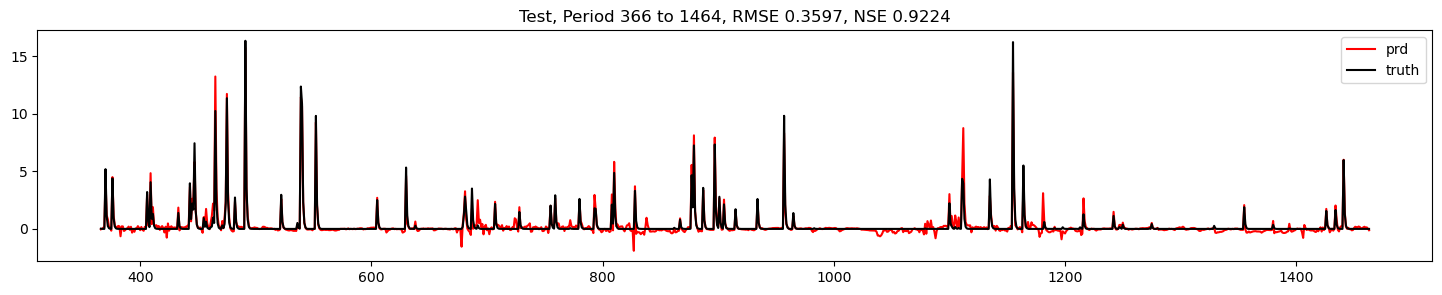

In [12]:
pred_test_agg = pred_test_itrs[0]
hidden_list_test_agg = hiddens_test_itrs[0]

output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]
x = test_x[:,:]
hidden_agg = hidden_list_test_agg.copy()
low = 366*1
high = 366*4
period = np.arange(low,high)
pred_snippet = pred_agg[period]
y_snippet = y[period]
x_snippet = x[period]

ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(period,pred_snippet,c='r', label='prd')
ax.plot(period,y_snippet,c='black', label='truth')
plt.title("Test, Period {} to {}, RMSE {:.4f}, NSE {:.4f}".format(low,high, np.sqrt(MSE(pred_snippet, y_snippet)), get_NSE(y_snippet, pred_snippet)))
plt.legend()
plt.show()
plt.close()

# Stateful Inference - Analysis daily RMSE

In [13]:
dates = df['Date'].values
doys = np.array([datetime.strptime(cdate, '%Y-%m-%d').date().timetuple().tm_yday for cdate in dates])

pred_test_agg = pred_test_itrs[0]
output_vars = np.asarray(output_vars)
output_var = output_vars[0]
idx = np.where(output_vars == output_var)[0][0]

doy = doys[train_len+valid_len:]
pred_agg = pred_test_agg[:,idx]
y = test_y[:,idx]

In [14]:
df_res = pd.DataFrame(data = {'doy':doy, 'pred':pred_agg, 'obs':y})
daily_rmses = []
assert(min(df_res['doy'])==1 and max(df_res['doy'])==366)
for i in range(1, 367):
    chunk = df_res[df_res['doy'] == i]
    daily_rmses.append(np.sqrt(MSE(chunk['pred'], chunk['obs'])))

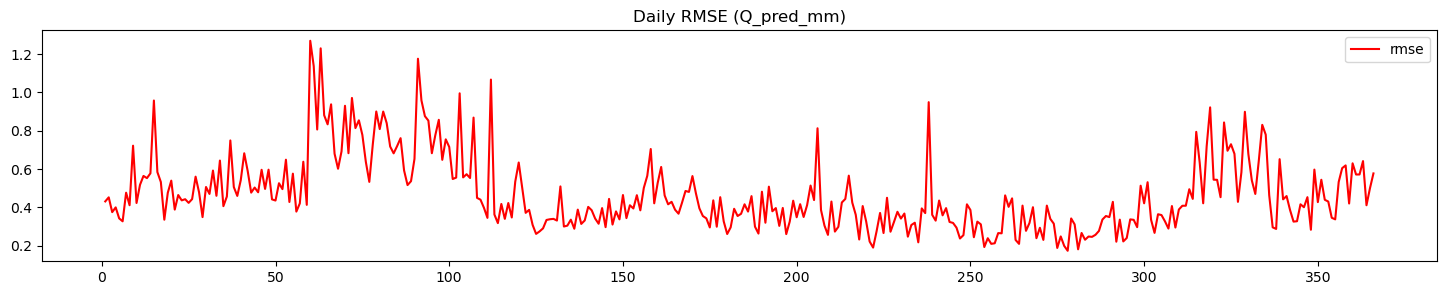

In [15]:
ig,ax = plt.subplots(1,1, figsize=(18,3))
ax.plot(np.arange(1,367),daily_rmses,c='r', label='rmse')
plt.title("Daily RMSE ({})".format(output_var))
plt.legend()
plt.show()
plt.close()